In [1]:
%matplotlib widget

In [2]:
import numpy as np
import equinox as eqx
import jax.numpy as jnp
import os
os.environ['ENABLE_PJRT_COMPATIBILITY'] = '1'
import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True)
import os
os.environ['JAX_PLATFORMS'] = 'cpu'
from typing import NamedTuple
from lcs.models import model
from tqdm import tqdm
from lcs.init_mpl import C0_, C1_
from lcs.mechanism import *
from lcs.plotting_utils import plot_traj
from lcs.shi22.shi22 import k_trajectory
from lcs.configs import *
import matplotlib.pyplot as plt
from lcs.curricula import get_cos
from lcs.mechanism import get_tape_2d
from jax.experimental.ode import odeint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lcs import PAGEHEIGHT, TEXTWIDTH
from matplotlib.cm import ScalarMappable

In [3]:
class Params(NamedTuple):
    c1: float
    c2: float
    w11: float
    w12: float
    w21: float
    w22: float

def model(x):
    c1, c2, w11, w12, w21, w22 = x

    c = jnp.array([c1, c2])
    W1 = jnp.array([w11, w12]).reshape(2, 1)
    W2 = jnp.array([w21, w22]).reshape(2, 1)

    W = jnp.stack([W1, W2])

    x_ = jnp.ones((1,))

    y = jnp.einsum('p,pij,j->i', c, W, x_)

    return y 

In [4]:
Y_tgts_flip = np.array([[1., 0.], 
                        [0., 1.]])[::-1]

base_block_duration = 1.0
long_short_ratio = 2
base_period = 2 * base_block_duration

long_block_duration = long_short_ratio * base_block_duration
long_period = 2 * long_block_duration
t_tot = 50

block_dur_cfg_ = dict(
    cfg_toy_,
    t_tot=t_tot,
    c_tau=.5 * base_block_duration / 10,
    W_tau=.5 * base_block_duration * 10,
)

s_ini = 1 / 1
wbar_ini_half = 0.4

w1 = jnp.array([0.5 + wbar_ini_half, 0.5 - wbar_ini_half]) * s_ini
w2 = jnp.array([0.5 - wbar_ini_half, 0.5 + wbar_ini_half]) * s_ini

p_init = dict(
    w11=w1[0],
    w12=w1[1],  
    w21=w2[0],
    w22=w2[1],
    c1=0.5,
    c2=0.5,
)

logger.setLevel(logging.ERROR)

all_tapes = []
block_durations = [base_block_duration, long_block_duration]
for block_duration_ in tqdm(block_durations):
    tapes = [
        get_tape_2d(
            Config(
                **dict(
                    block_dur_cfg_,
                    Y_tgt=get_n_phasic_curriculum(g, block_duration_, *Y_tgts_),
                    block_duration=block_duration_,
                    W_teachers=Y_tgts_.reshape(2, 2, 1),
                    T_tape=1000,
                    dt=1e-3,
                )
            ),
            p_init,
            full2toy=full2toy_6d,
            toy2full=toy2full_6d,
        )
        for Y_tgts_ in [Y_tgts_flip, Y_tgts_flip[::1]]  # averaging here will make it too symmetric, as w1 gains over w2 and w2 gains over w1?
    ]

    Tape = new_tape_type(asdict(tapes[0]).keys())
    tapes = [Tape(**asdict(t)) for t in tapes if t is not None]
    tape = jax.tree.map(lambda x, y: (x + y) / 2, tapes[0], tapes[1])
    all_tapes += [tape]
logger.setLevel(logging.INFO)

W0000 00:00:1729783346.799487 27542053 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1729783346.806697 27542053 service.cc:145] XLA service 0x168db86a0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729783346.806719 27542053 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1729783346.808281 27542053 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1729783346.808290 27542053 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


In [5]:
fig, (ax_V, ax) = plt.subplots(1, 2, figsize=(12, 6))

wbar_ = jnp.linspace(0, 1, 100)

err_norm_ini = jnp.linalg.norm(jnp.array([-.5, .5]))
lr_c = block_dur_cfg_['c_tau']**-1
lr_W = block_dur_cfg_['W_tau']**-1

C = lr_c * lr_W \
        * (2 * 1/2) \
        * ((2*wbar_ini_half) * err_norm_ini * err_norm_ini)

tau_b = block_dur_cfg_['block_duration']
print(f"tau_b: {tau_b}")

def w_bar_t(t, tau_b=tau_b):

    N_periods = .5 * t / tau_b

    return  2*wbar_ini_half + N_periods * 1/2 * C * tau_b**2

def w_bar_parabola(t, tau_b=1.):
    """
    Within single block dynamics
    """
    return 2*wbar_ini_half + 1/2 * C * t**2

T = 2*tau_b # period
omega = 2*np.pi/T

cosine = get_cos(1000, T, 2*T)
# c is [.9, .1] on the unit circle

phi_t = lambda t: jnp.arccos(jnp.clip(cosine(t) * 2 - 1, -1, 1))

# phi_t = lambda t: omega * t

R_fn = lambda phi: jnp.array([[jnp.cos(phi), -jnp.sin(phi)], 
                              [jnp.sin(phi), +jnp.cos(phi)]])

def V_lin(xy, t):
        R_xy =  xy@R_fn(phi_t(t)).T
        x, y = R_xy[..., 0], R_xy[..., 1]
        return -lr_W * x  # TODO what is the right coefficient here? I think it is just 1.

power = 3/2*1
def V_quad(xy, t, tau_b=tau_b):
    """
    The idea is to define a potential that would under gradient descent give the same time dynamics for wbar as we find
    through a Taylor expansion in the paper. 

    Let z := wbar for brevity

    We have found in the paper
    z(t) = D t^2,
    D = 1/4 C * tau_b
    and now make this a requirement for finding a potential V.

    Derivation for V(z):
    d^2/dt^2 z 
    (GD)        = -d/dt dV/dz 
                = -dz/dt d/dz dV/dz
                = -dz/dt d^2V/dz^2
    (use req.)  = -t d^2V/dz^2
                
    => d^2V/dz^2 propto t
    Ansatz
    V(z) = -C z^a
    d^2V/dz^2 = C a (a-1) z^(a-2)
    Use z = t^2:
    d^2V/dz^2 = C a (a-1) (t^2)^(a-2) = C a (a-1) t^(2a-2)
    => 2a-2 = 1
    => a = 3/2

    ===> V(z) = -C z^(3/2)
    """
    R_xy =  xy@R_fn(phi_t(t)).T
    x, y = R_xy[..., 0], R_xy[..., 1]
    return -1/4 * tau_b * C * (jnp.abs(x)**power)

coef_lin = 1.
coef_quad = 1.
def V_tot(xy, t, tau_b=tau_b):
    V_base = coef_lin*V_lin(xy, t) + coef_quad*V_quad(xy, t, tau_b)
    nrm = jnp.linalg.norm(xy, axis=-1)
    V_wall = (jnp.tanh(30*(nrm - 1.)) + 1.) * nrm**(power*2)
    return V_base + V_wall

grad_V_2D_tot = jax.grad(V_tot, 0)


# asspcoicated GD potetial is just w_bar**2
def V_eff(wbar, tau_b):
    # we now that the second derivative of wbar is linear in wbar
    # -> harmonic oscillator

    # d^2/dt^2 wbar = F = -dV/dwbar = -2 wbar

    # -> V = int_wbar F dwbar = int_wbar d^2/dt^2 wbar 

    # the solution will indeed be a harmonic oscillator

    return - 1/2 * (.5 * 1 / tau_b) * (2*C * wbar_ini_half) * tau_b**2 * wbar**2

grad_V_eff = jnp.vectorize(jax.grad(V_eff, 0))


# simulate the classical motion in the potential
t_eval = jnp.linspace(0, 10., 300)

def sim_dynamics(wbar_ini, tau_b=tau_b):
    # Assuming grad_V_2D_tot and tau_b are defined elsewhere
    gamma = 1.  # friction constant to get into overdamped motion regime

    # Define the system of differential equations
    @jax.jit
    def rhs(z, t):
        x, y, vx, vy = z  # unpack the state vector
        x_vec = jnp.array([x, y])

        F_x, F_y = -grad_V_2D_tot(x_vec, t, tau_b)  # calculate the forces

        m = 0.025  # small mass, inertia term drops out while other forces stay O(1)

        # NEWTONIAN DYNAMICS
        DYN = "gd"
        if "newton" in DYN:
            ax = F_x / m - gamma * vx  # acceleration in x
            ay = F_y / m - gamma * vy  # acceleration in y

        else:
            vx = lr_W*F_x
            vy = F_y
            ax = 0.
            ay = 0.

        # Return the derivatives
        return jnp.array([vx, vy, ax, ay])

    # Initial conditions: [position, velocity]
    x0 = jnp.array([wbar_ini, 0, 0, 0])

    # Solving the system of ODEs with JAX's odeint
    result = odeint(rhs, x0, t_eval)

    y = result[:, :2]  # get the position (first two components)

    # Pad missing values if the result has fewer time steps than t_eval
    if y.shape[0] < t_eval.shape[0]:
        y = jnp.pad(y, ((0, t_eval.shape[0] - y.shape[0]), (0, 0)), mode='edge')

    # Return the classical trajectories
    return y


interp_nd = jax.vmap(jnp.interp, in_axes=(None, None, -1), out_axes=(-1))

wbar_ini_half_ = 0.1
traj = sim_dynamics(tau_b=tau_b, wbar_ini=wbar_ini_half_)
traj_t = lambda t: interp_nd(t, t_eval, traj)

trajb = sim_dynamics(tau_b=tau_b, wbar_ini=-wbar_ini_half_)
trajb_t = lambda t: interp_nd(t, t_eval, trajb)

print(traj_t(t_eval).shape)

tau_b: 1.0
(300, 2)


In [6]:
# # make a 3d plot
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

x = np.linspace(-1, 1, 101) * 1.05
y = np.linspace(-1, 1, 101) * 1.05

X, Y = np.meshgrid(x, y)

#plot vertical line trhough (0, 0)

ax.set_zlim(-2, 2)


def update(t, ax=None, ax2=None):
    phi_ = phi_t(t)
    X_vec = np.stack([X, Y], axis=-1)

    Z = V_tot(X_vec, t)


    X_traj_t_ = traj_t(t).reshape(1, -1)
    X_trajb_t_ = trajb_t(t).reshape(1, -1)

    dw = jnp.abs(X_traj_t_[..., 0] - X_trajb_t_[..., 0])[0]

    # eval_slice
    y_traj_tiled = np.repeat(X_traj_t_[..., 1], len(x))
    X_eval = np.stack([x, y_traj_tiled], axis=-1)
    
    V_lin_eval = coef_lin*V_lin(X_eval, t)
    V_quad_eval = coef_quad*V_quad(X_eval, t)
    V_tot_eval = V_tot(X_eval, t)

    if ax is not None:
        ax.clear()
        ax.plot([0, 0], [0, 0], [-2, 2], c='k', lw=2)
        ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_title(f't={t:.2f}, phi = {phi_:.2f}')
        ax.plot(X_traj_t_[..., 0], X_traj_t_[..., 1], V_tot(X_traj_t_, t)+0.1, marker='o')
        ax.set_zlim(None, 2.)

    if ax2 is not None:
        ax2.clear()

        ax2.plot(x, V_lin_eval, label='V_lin', ls=':', alpha=.5, c='k')
        ax2.plot(x, V_quad_eval, label='V_quad', ls='--', alpha=.5, c='k')
        ax2.plot(x, V_tot_eval, label='V_tot', ls='-', alpha=1, c='k')

        ax2.set_ylim(-5, 2)
        ax2.set_xlim(*ax2.get_xlim())

        # X_vec_traj_t_x = X_vec_traj_t.copy()
        
        ax2.plot(X_traj_t_[..., 0], V_tot(X_traj_t_, t), marker='o')
        ax2.plot(X_trajb_t_[..., 0], V_tot(X_trajb_t_, t), marker='o')

        xa = X_traj_t_[..., 0].squeeze()
        xb = X_trajb_t_[..., 0].squeeze()

        # make arrow connecting these vertically at .8 of axis height
        from matplotlib.transforms import blended_transform_factory
        transform = blended_transform_factory(ax2.transData, ax2.transAxes)
        ax2.annotate(r'', xy=(xa, .8), xytext=(xb, .8), xycoords=transform, textcoords=transform, arrowprops=dict(arrowstyle='|-|', lw=2, mutation_scale=3), va='center', )
        ax2.text((xa + xb) / 2, .9, r"$\bar w$", ha='center', va='center', transform=transform)


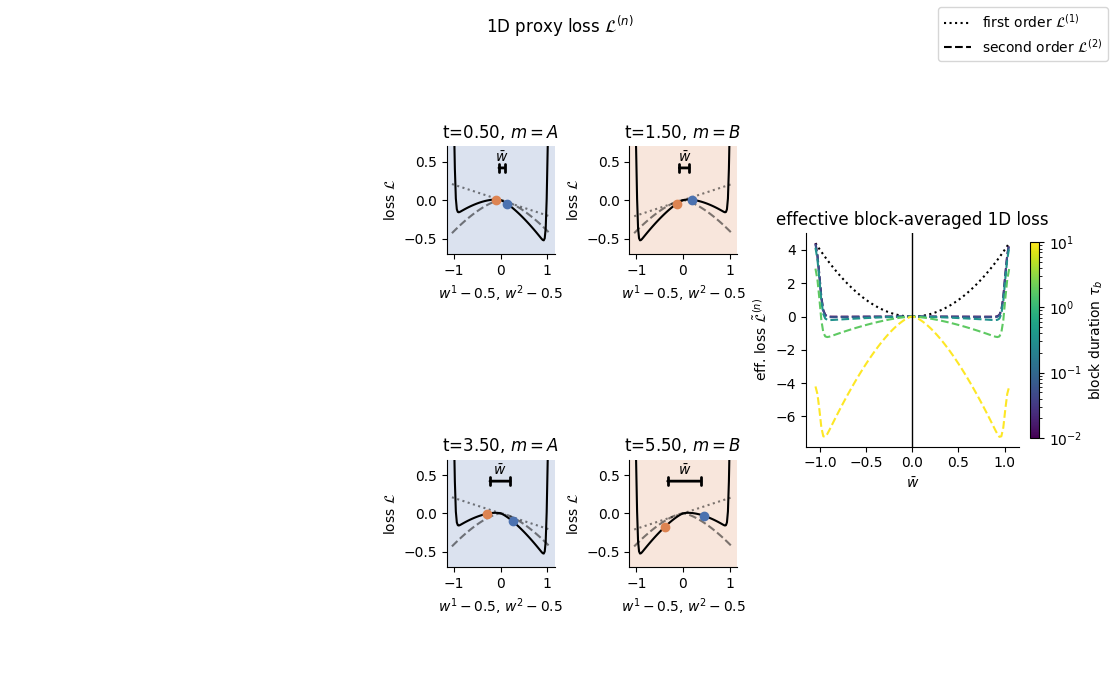

In [7]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH, s*PAGEHEIGHT*.3), layout='constrained')

subfigs = fig.subfigures(1, 3)

# A: 2d dynamics
# B: time-d 1d potential
# C: effective 1d-potential

def V_eff_second_order(wbar, tau_b=1.):
    V_tot_1 = V_tot(jnp.array([wbar, 0*wbar]).T, t=0., tau_b=tau_b)
    V_tot_2 = V_tot(jnp.array([wbar, 0*wbar]).T, t=T*1.1, tau_b=tau_b)

    return V_tot_1 + V_tot_2

@jnp.vectorize
def V_eff_first_order(wbar, tau_b=1.):
    y = jnp.array([.5 + wbar, .5 - wbar])
    y1 = jnp.array([1, 0])
    y2 = jnp.array([0, 1])

    loss = (y - y1).T@(y-y1) + (y - y2).T@(y-y2)
    loss -= 1. # subtract the offset, just a constant that does not affect the gradient dynamics
    return loss



sfig = subfigs[1]
axes = sfig.subplots(2, 2)

for iax, ax in enumerate(axes.flat):
    t_ax = np.linspace(0, t_eval.max(), axes.size)[iax]
    t_ax = [0.5, 1.5, 3.5, 5.5, 7.5][iax]
    update(t_ax, ax=None, ax2=ax)
    if iax % 2 == 0:
        # make ax background a color
        ax.set_facecolor(('C0', .2))
    else:
        ax.set_facecolor(('C1', .2))
    ax.set_title(f't={t_ax:.2f}, $m={"A" if iax % 2 == 0 else "B"}$')
    ax.set_box_aspect(1)
    ax.set_xlabel(r'${w}^1 - 0.5$, ${w}^2 - 0.5$')
    ax.set_ylabel(r'loss $\mathcal{L}$')

    ax.set_ylim(-.7, .7)

sfig.suptitle(r'1D proxy loss $\mathcal{L}^{(n)}$')

sfig = subfigs[-1]
ax = sfig.subplots(1, 1)
ax.set_title('effective block-averaged 1D loss' 
             )
wbar = np.linspace(-1.05, 1.05, 100)
l1, = ax.plot(wbar, V_eff_first_order(wbar), label=r"first order $\mathcal{L}^{(1)}$", ls=':', c='k') ##eff loss
tau_b_range = np.geomspace(1e-2, 1e1, 5)

cmap = plt.get_cmap('viridis')
norm = LogNorm(vmin=tau_b_range.min(), vmax=tau_b_range.max())
l2, = ax.plot(wbar, V_eff_second_order(wbar, tau_b=1.), label=r"second order $\mathcal{L}^{(2)}$", ls='--', c='k', alpha=1)
l2.remove()
for tau_b_ in tau_b_range:
    ax.plot(wbar, V_eff_second_order(wbar, tau_b=tau_b_), label=f"second order, tau_b={tau_b_:.2f}", ls='--', c=cmap(norm(tau_b_)))
ax.set_xlabel(r'$\bar{w}$')

ax.axvline(0, c='k', lw=1, ls='-')
ax.set_box_aspect(1)
ax.set_ylabel(r'eff. loss $\tilde\mathcal{L}^{(n)}$')

#pseudo cbar
sm = ScalarMappable(norm=norm, cmap='viridis')

fig.colorbar(sm, ax=ax, label=r'block duration $\tau_b$', shrink=0.3)
fig.legend([l1, l2], [l1.get_label(), l2.get_label()])

fig

In [8]:
# now plot sim dyn
sfig = subfigs[0]
ax = sfig.subplots(1, 1)
ax.cla()
ax.axis('off')

### IMPORT PANEL FROM FIG_MECHANISM notebook

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))